In [226]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import cv2
import seaborn as sns

In [227]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [228]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
experiment = "Lung"
core = "B5"
datasets = [
    core + "_1",
    core + "_2",
    core + "_3",
    core + "_4",
]

# Get images

In [230]:
from typing import List
from skimage import measure
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from functools import partial
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from skimage.filters import threshold_otsu

h5_data_dir = p_dir / "data" / "h5"

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img, n_min=1, n_max=99):
    # Contrast stretching
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


# Read mask image
def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    try:
        border = info['border']
        img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT, None, value = 0)
    except: pass
    img = rotate(img, rotation, resize=True)
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]

    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img

def get_img_subset(imgs, markers, labels):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(imgs[idx])
    return np.stack(imgs_subset, axis=2)


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [231]:
imgs_imc_all = {}
masks = get_masks(data_dir / "masks", f"{experiment}_{core}")

for dataset in datasets:
    imgs, markers = get_imgs(f"{experiment} {core}", "IMC")
    imgs_imc_all[f"{experiment}_{dataset}"] = imgs

In [232]:
for dataset in datasets:
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    
    imgs_imc = imgs_imc_all["_".join([experiment, dataset])]
    mask = masks["_".join([experiment, dataset])]


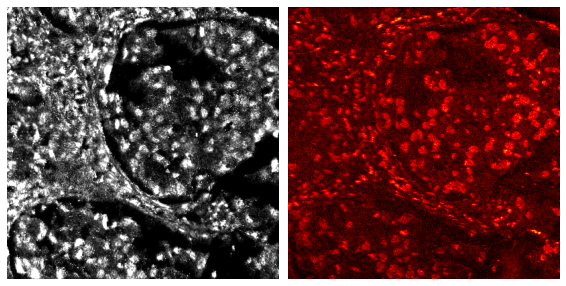

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


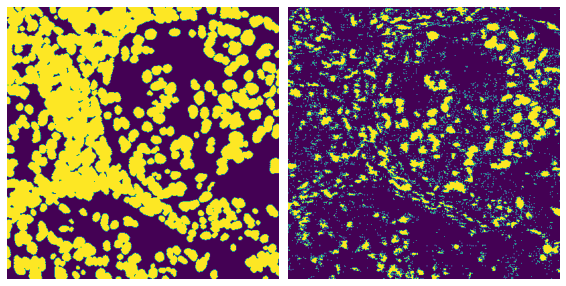

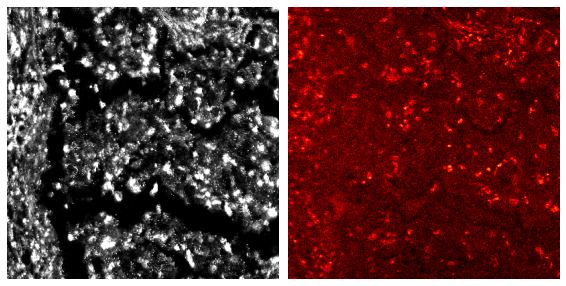

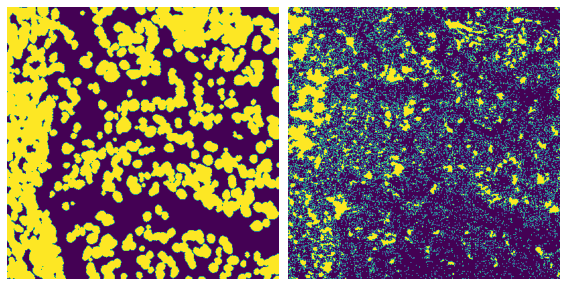

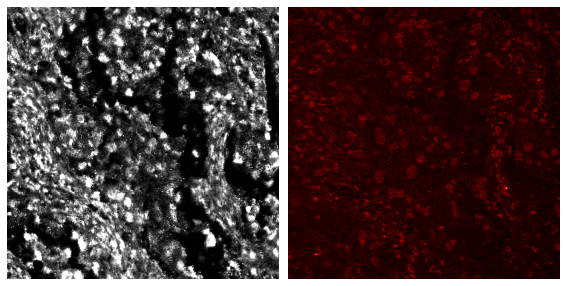

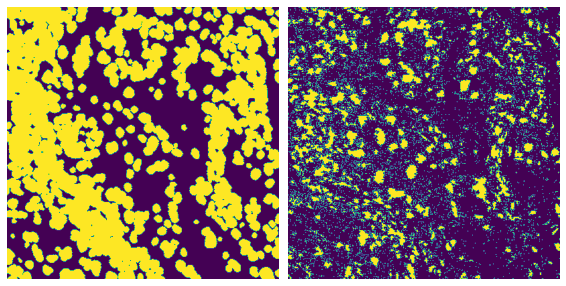

In [233]:
from scipy import ndimage
from collections import defaultdict
from skimage.registration import phase_cross_correlation
from skimage import morphology

subset = ["HistoneH3"]
info_dict = defaultdict(list)

for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue

    # ---- Load IMC image
    img_dapi = np.sum(imgs_imc[[markers.index(marker) for marker in subset]], axis=0)
    img_dapi = contrast_stretching(img_dapi)
    img = crop_img(img_dapi, info)
    img = contrast_stretching(img, n_max=95)

    # ---- Load SIMS images
    imgs, labels = get_imgs_sims(experiment, dataset)
    # Read nulcie channel
    img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=img.shape[0])
    # Contrast streching
    p2, p98 = np.percentile(img_nuclei_downscale, (1, 100))
    img_nuclei_downscale = exposure.rescale_intensity(
        img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 255)
    )
    img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)

    # Plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap="gray")
    ax[1].imshow(img_nuclei_downscale, cmap="hot")
    ax[0].axis("off")
    ax[1].axis("off")
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    
    # Get binary images
    thresh = threshold_otsu(img_nuclei_downscale)
    binary_sims = img_nuclei_downscale > thresh
    binary_sims = ndimage.binary_fill_holes(binary_sims).astype(np.uint8)
    binary_sims = morphology.remove_small_objects(binary_sims, 40).astype(np.uint8)
    
    # thresh = threshold_otsu(img)
    # binary_imc = img > thresh
    # binary_imc = ndimage.binary_fill_holes(binary_imc).astype(np.uint8)
    binary_imc = (masks["_".join([experiment, dataset])]>0).astype(np.uint8)
    
    # Plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(binary_imc)
    ax[1].imshow(binary_sims)
    ax[0].axis("off")
    ax[1].axis("off")
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    
    # iou = _intersection_over_union(binary_imc, binary_sims)
    
    info_dict['Dataset'].append(dataset)
    info_dict['Registered'].append(np.sum(cv2.bitwise_and(binary_sims, binary_imc))/np.sum(binary_sims))
    info_dict['Flipped'].append(np.sum(cv2.bitwise_and(binary_sims[::-1,::-1], binary_imc))/np.sum(binary_sims))

In [241]:
df = pd.DataFrame(info_dict)

In [242]:
df_subset = df.melt(id_vars=['Dataset'], var_name='Mode', value_name='IoU')

In [243]:
df_subset

,Dataset,Mode,IoU
0,B5_1,Registered,0.733984
1,B5_2,Registered,0.658342
2,B5_3,Registered,0.753274
3,B5_1,Flipped,0.519206
4,B5_2,Flipped,0.477116
5,B5_3,Flipped,0.528498


[Text(0, 0, 'Registered'), Text(1, 0, 'Flipped')]

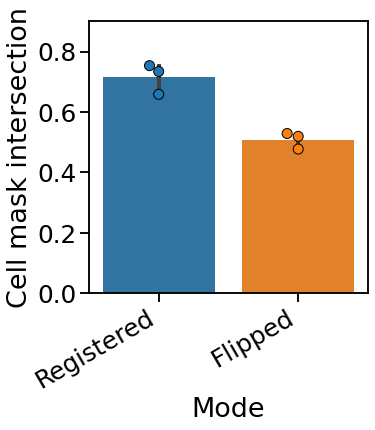

In [248]:
sns.set_context("talk", font_scale=1.5)

hue_plot_params = {
    'data':      df_subset,
    'x':         'Mode',
    'y':         'IoU',
}

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.barplot(**hue_plot_params)
ax = sns.swarmplot(**hue_plot_params, dodge=True, edgecolor='k', linewidth=1.0, size=10)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Cell mask intersection")
ax.set_ylim([0, 0.9])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')